In [204]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [205]:
# plt.style.use('./deeplearning.mplstyle')

In [206]:
DATA_DIR = 'images_3/'

In [207]:
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_valid_dir = os.path.join(DATA_DIR, 'val/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask')

x_test_dir = os.path.join(DATA_DIR, 'test/img')
y_test_dir = os.path.join(DATA_DIR, 'test/mask')

Downloader and Utility Functions

In [208]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# cmap='gray', vmin=0, vmax=255

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        if classes is not None:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        else:
            self.class_values = None

        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Get the image filename
        image_id = self.ids[i]
        image_path = self.images_fps[i]
        mask_path = self.masks_fps[i]


        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        if self.class_values is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')

            if mask.shape[-1] != 1:
                background = 1 - mask.sum(axis=-1, keepdims=True)
                mask = np.concatenate((mask, background), axis=-1)
        else:
            # Treat as binary mask (normalize and add channel dimension)
            mask = (mask / 255.0).astype('float32')
            mask = np.expand_dims(mask, axis=-1)

        # # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

Original image shape: (352, 768, 3)
Original image range: 0 to 255


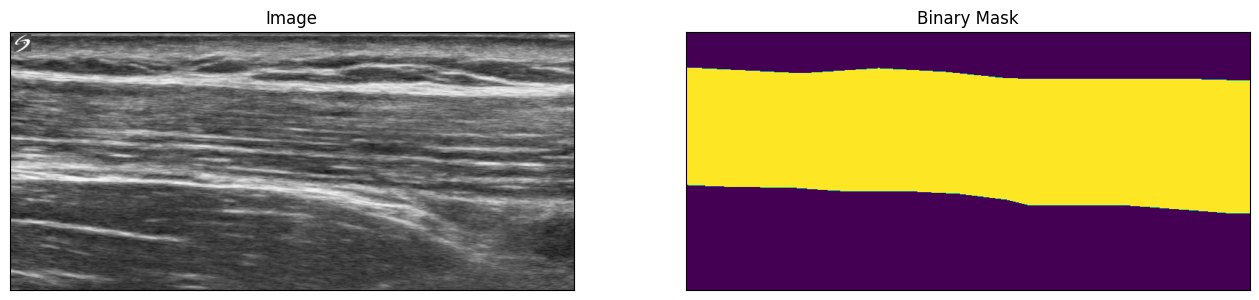

In [209]:
dataset = Dataset(x_train_dir, y_train_dir)  # No need to pass `classes`
dataset = Dataset(x_train_dir, y_train_dir)  # No need to pass `classes`

image, mask = dataset[5]
print("Original image shape:", image.shape)
print("Original image range:", image.min(), "to", image.max())
visualize(
    image=image,
    binary_mask=mask.squeeze()  # or mask[..., 0] if you prefer
)


Augmentations

In [210]:
import albumentations as A

In [211]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        # A.Resize(height=352, width=768),  # ✅ safe size
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # A.PadIfNeeded(min_height=320, min_width=320, border_mode=0),
        # A.RandomCrop(height=320, width=320),

        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),  # ✅ updated line
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),

        A.Lambda(mask=round_clip_0_1)
    ]

    return A.Compose(train_transform)


def get_validation_augmentation():
    return A.Compose([
        A.Resize(352, 768)  # ✅ ensure compatibility
    ])

# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         A.PadIfNeeded(384, 480)
#     ]
#     return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

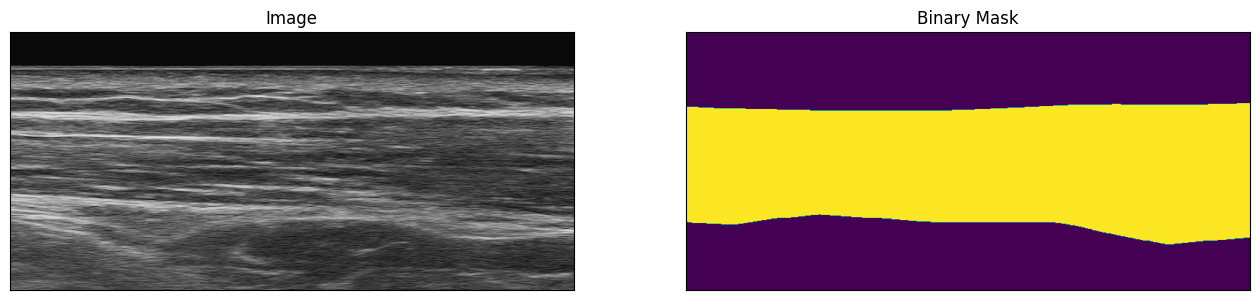

In [212]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample

visualize(
    image=image,
    binary_mask=mask.squeeze()  # or mask[..., 0] if you prefer
)


Segmentation Model Training

In [213]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [224]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
# CLASSES = ['car']
LR = 0.0001
EPOCHS = 2

preprocess_input = sm.get_preprocessing(BACKBONE)

In [225]:
# # define network parameters
n_classes = 1   # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

In [226]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + focal_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [242]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=None,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=None,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 352, 768, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 352, 768, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         'best_model.h5',
#         monitor='val_loss',
#         save_weights_only=True,
#         save_best_only=True,
#         mode='min'
#     )
# ]

C:\Users\kisho\PycharmProjects\UHN\US Image Processing CNN\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [243]:
# train model
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

# history = model.fit_generator(
#     train_dataloader,
#     steps_per_epoch=len(train_dataloader),
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     validation_data=valid_dataloader,
#     validation_steps=len(valid_dataloader),
# )

Epoch 1/2
12/12 [==============================] - 262s 20s/step - loss: 0.5822 - iou_score: 0.4944 - f1-score: 0.6572 - val_loss: 3.1877 - val_iou_score: 0.5066 - val_f1-score: 0.6724 - lr: 1.0000e-04
Epoch 2/2
12/12 [==============================] - 228s 19s/step - loss: 0.4793 - iou_score: 0.6015 - f1-score: 0.7491 - val_loss: 2.6844 - val_iou_score: 0.5141 - val_f1-score: 0.6789 - lr: 1.0000e-04


In [246]:
# # Load best weights before saving full model
model.load_weights('best_model.h5')
model.save('best_model_full.h5')

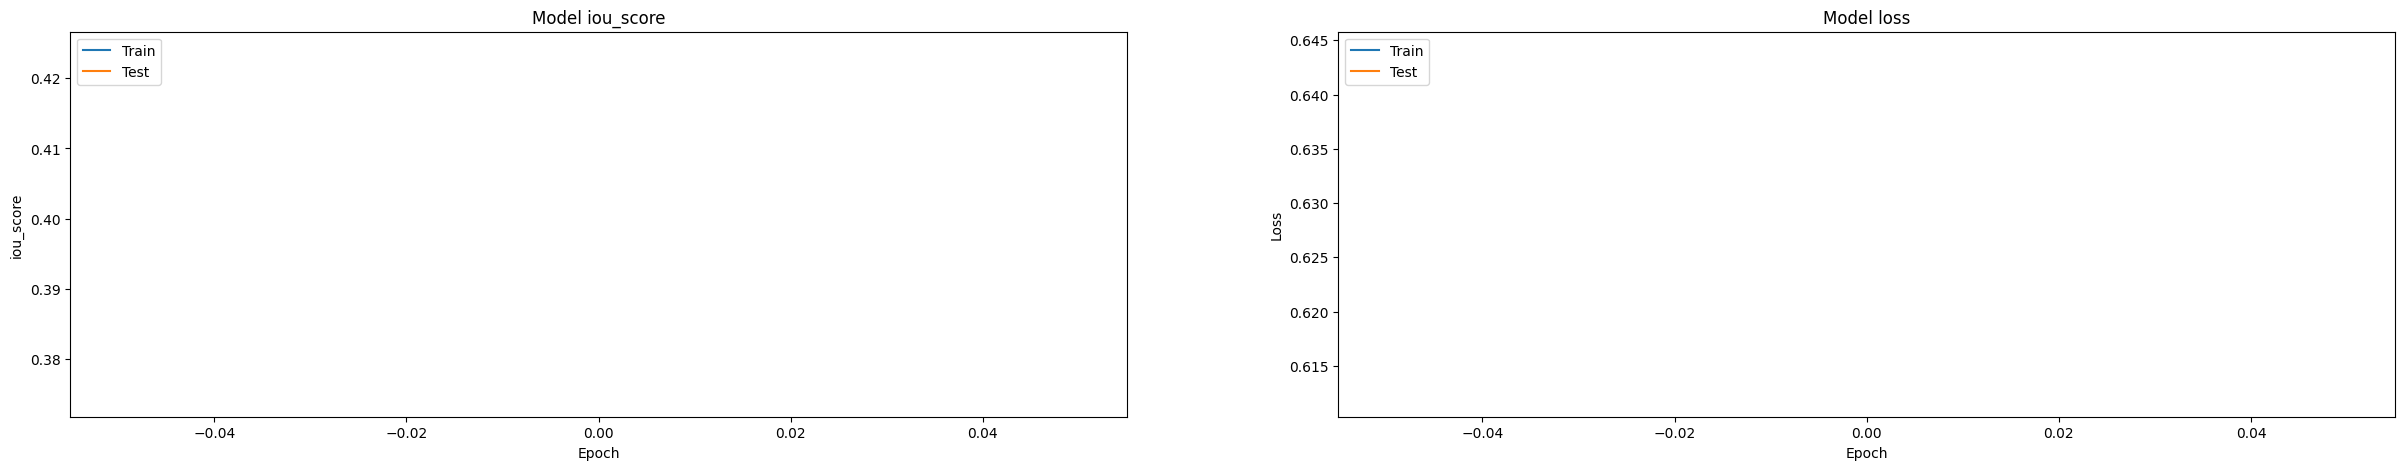

In [220]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model Evaluation

In [244]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=None,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [245]:
# model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

# load best weights
model.load_weights('best_model.h5')

In [237]:
# scores = model.evaluate_generator(test_dataloader)
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

5/5 [==============================] - 3s 597ms/step - loss: 1.4995 - iou_score: 0.4848 - f1-score: 0.6530
Loss: 1.4995
mean iou_score: 0.48484
mean f1-score: 0.65304


Visualization of Results on Test Dataset

1/1 [==============================] - 1s 565ms/step


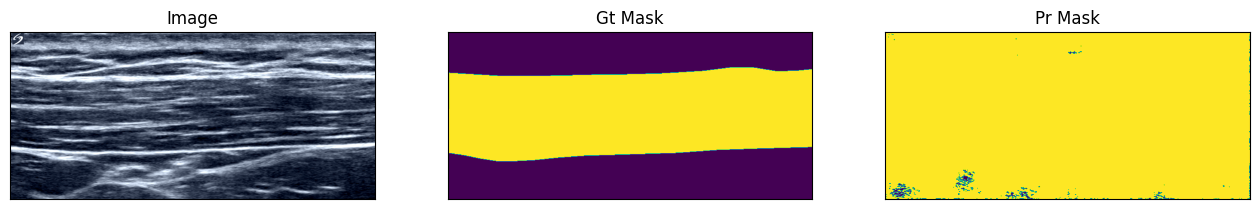

1/1 [==============================] - 1s 533ms/step


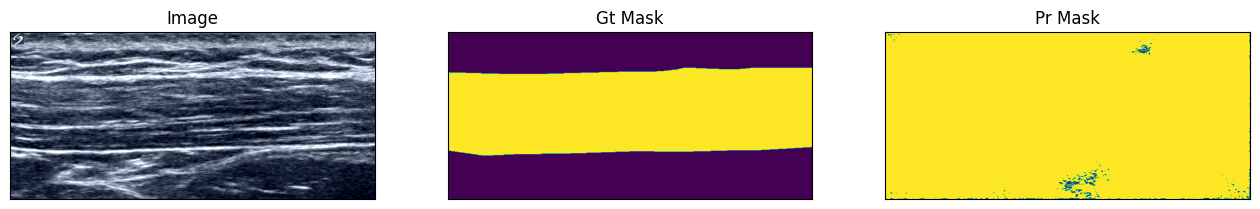

1/1 [==============================] - 1s 533ms/step


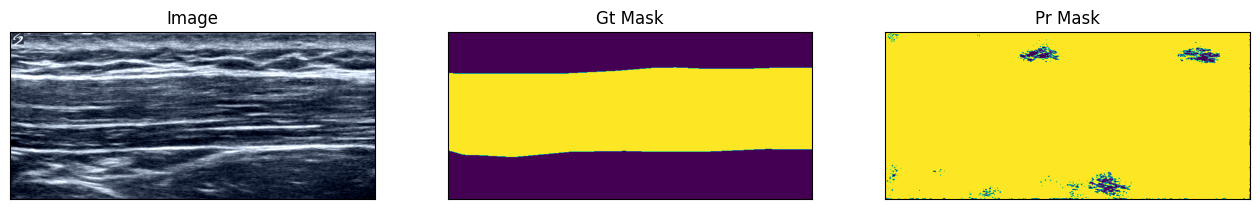

1/1 [==============================] - 1s 560ms/step


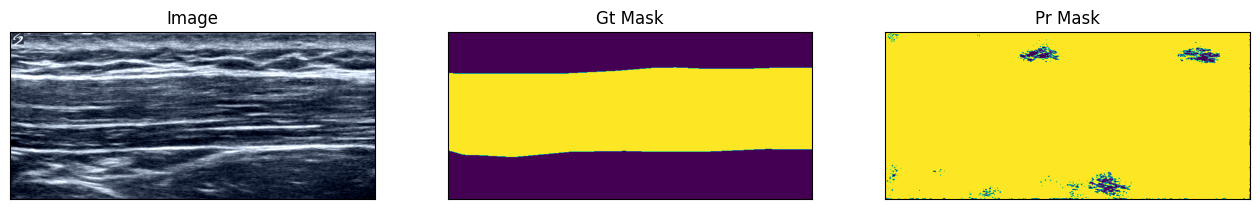

1/1 [==============================] - 1s 531ms/step


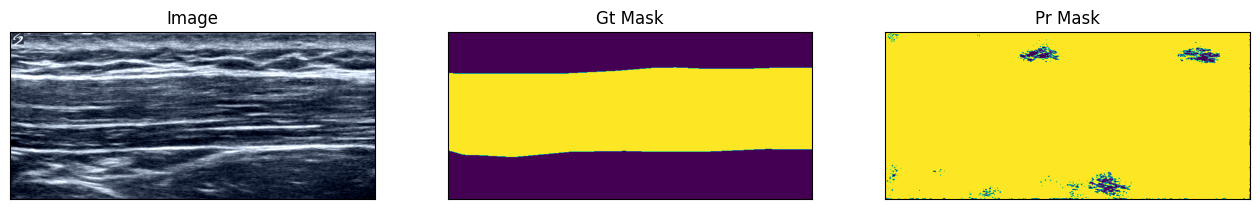

In [247]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )


In [ ]:
pr_mask[..., 0].squeeze()

masked_image = denormalize(image.squeeze()) * np.expand_dims(pr_mask.squeeze(), axis=-1)

Obtain Cropped Image - ALL IMAGES

In [202]:
# load best weights
model.load_weights('best_model.h5')

# DATE: 15:16 on June 30, 2025.
# membrane does not work (from testing phase with different dataset)
# best_model is the best model, use for subsequent steps

0
1/1 [==============================] - 0s 430ms/step


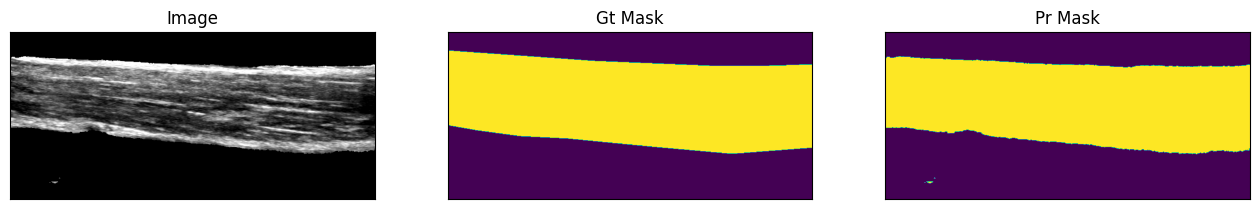

1
1/1 [==============================] - 0s 445ms/step


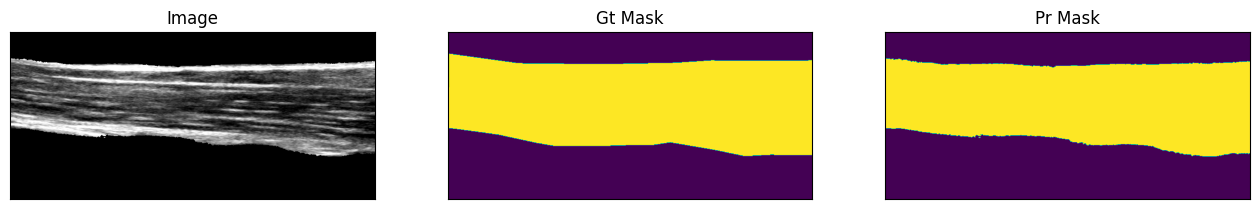

2
1/1 [==============================] - 1s 524ms/step


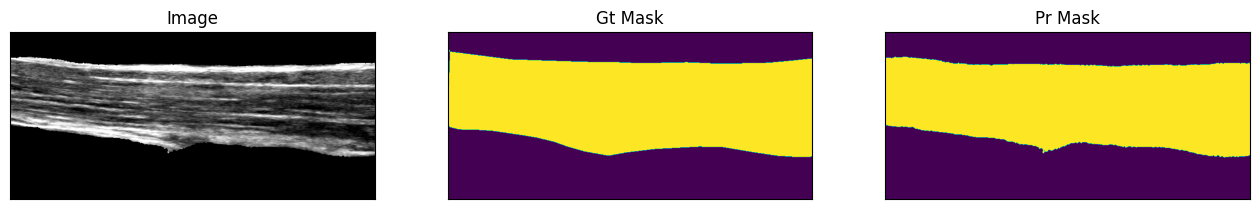

3
1/1 [==============================] - 0s 454ms/step


4
1/1 [==============================] - 0s 432ms/step


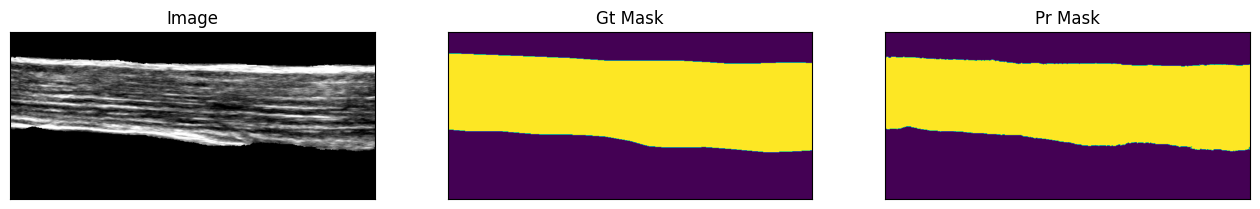

5
1/1 [==============================] - 0s 445ms/step


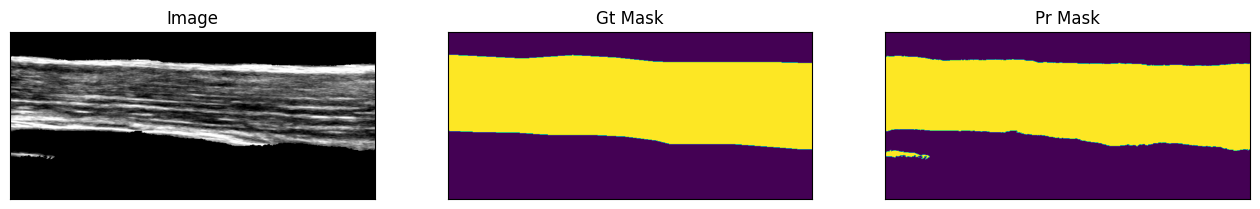

6
1/1 [==============================] - 0s 432ms/step


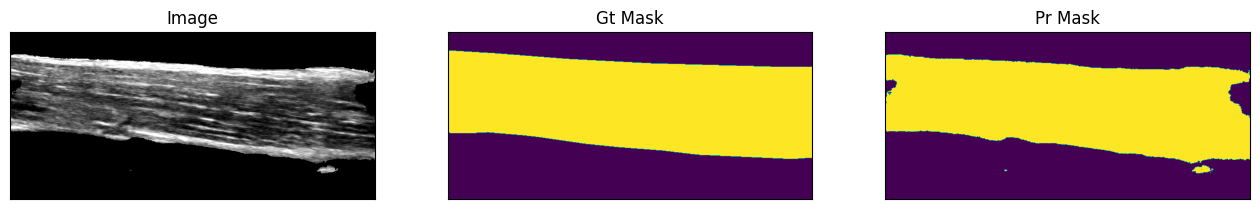

7
1/1 [==============================] - 0s 448ms/step


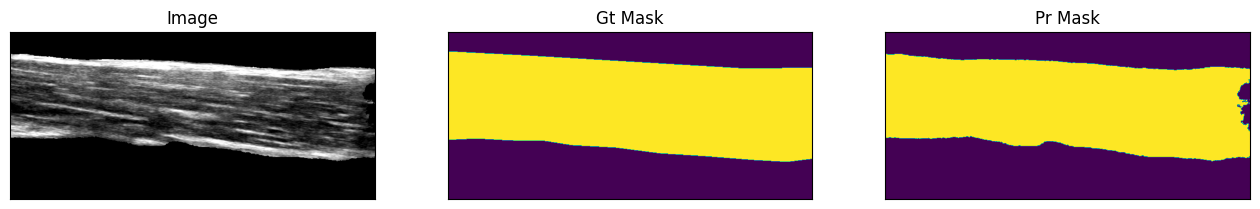

8
1/1 [==============================] - 0s 440ms/step


9
1/1 [==============================] - 0s 437ms/step


10
1/1 [==============================] - 0s 437ms/step


11
1/1 [==============================] - 1s 506ms/step


12
1/1 [==============================] - 0s 434ms/step


13
1/1 [==============================] - 0s 428ms/step


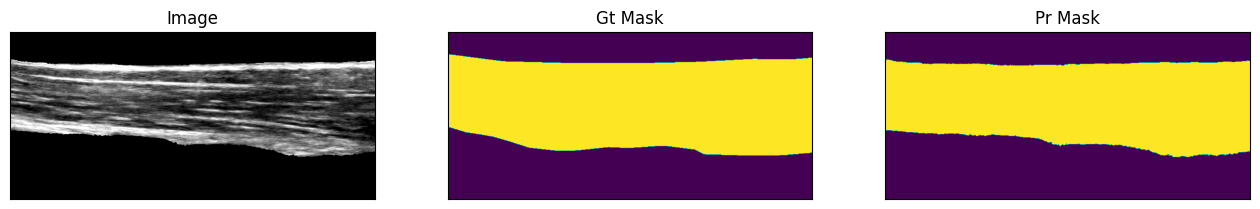

14
1/1 [==============================] - 0s 423ms/step


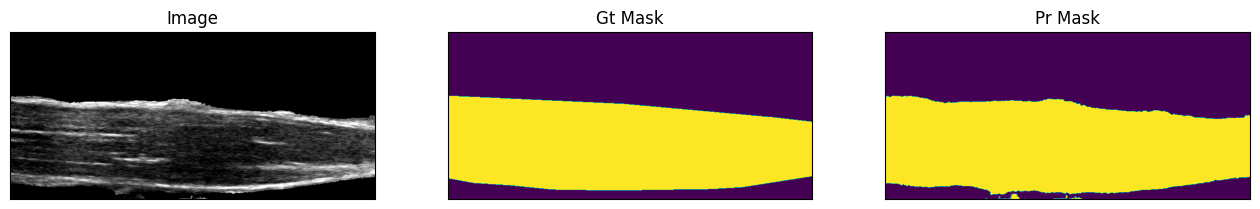

15
1/1 [==============================] - 0s 430ms/step


16
1/1 [==============================] - 0s 419ms/step


17
1/1 [==============================] - 1s 508ms/step


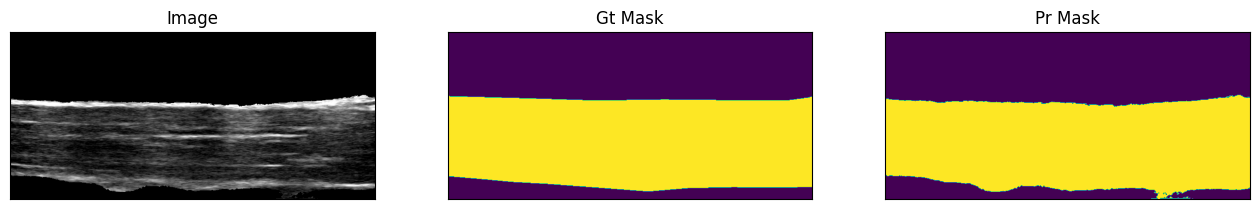

18
1/1 [==============================] - 0s 427ms/step


19
1/1 [==============================] - 0s 421ms/step


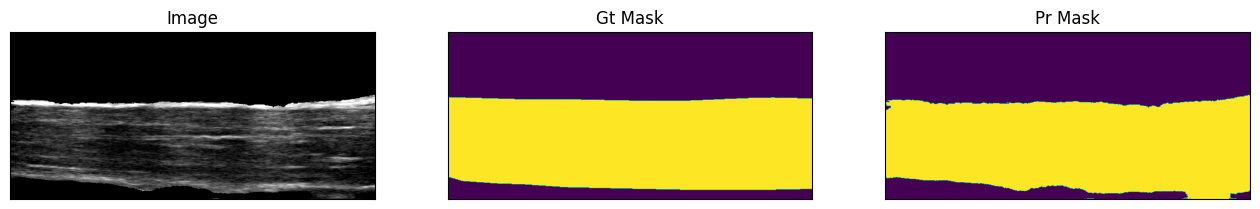

20
1/1 [==============================] - 0s 428ms/step


21
1/1 [==============================] - 0s 438ms/step


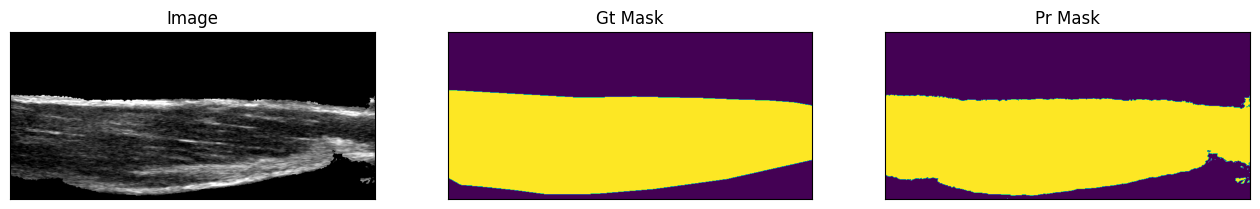

22
1/1 [==============================] - 0s 422ms/step


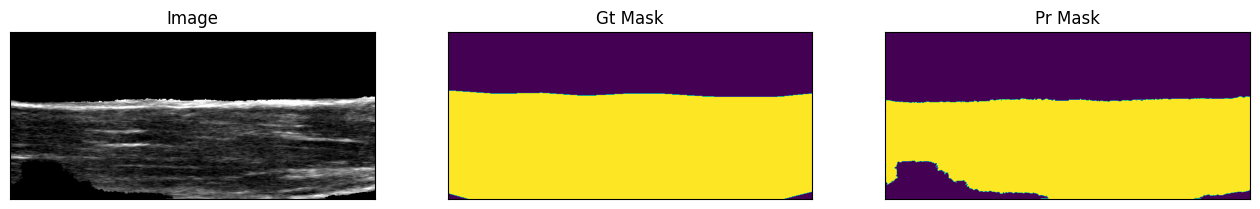

23
1/1 [==============================] - 0s 432ms/step


24
1/1 [==============================] - 0s 428ms/step


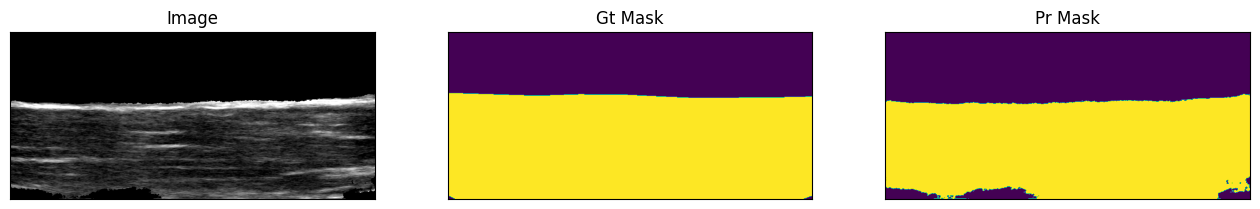

25
1/1 [==============================] - 0s 422ms/step


26
1/1 [==============================] - 0s 434ms/step


27
1/1 [==============================] - 0s 427ms/step


28
1/1 [==============================] - 0s 421ms/step


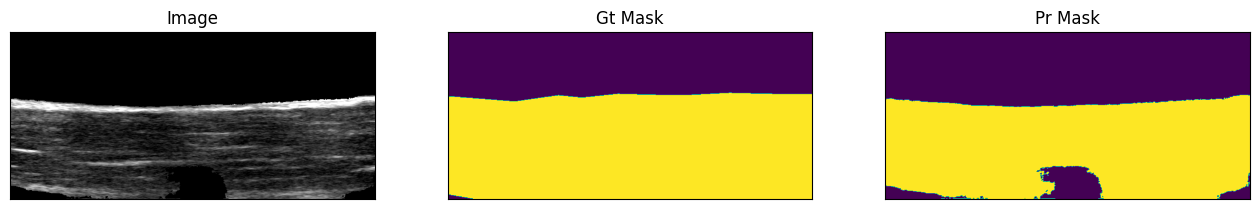

29
1/1 [==============================] - 0s 436ms/step


30
1/1 [==============================] - 0s 435ms/step


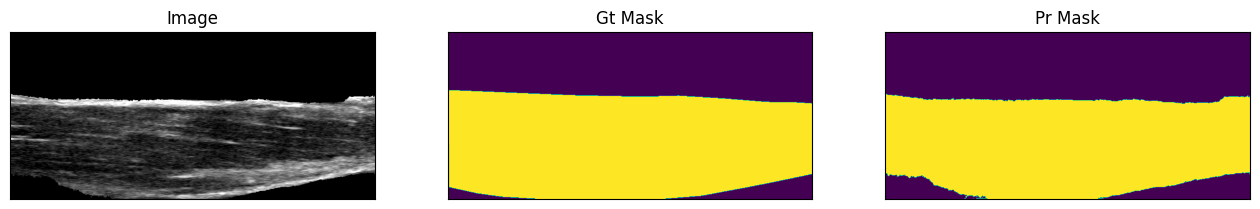

31
1/1 [==============================] - 0s 423ms/step


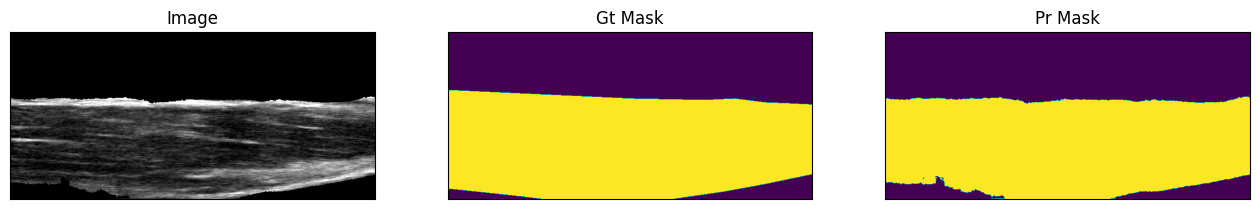

32
1/1 [==============================] - 0s 449ms/step


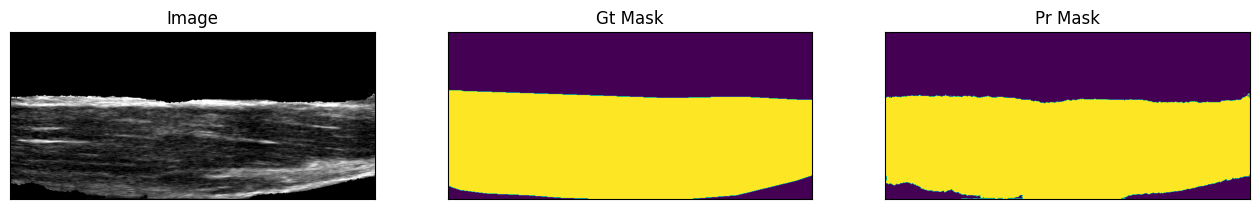

33
1/1 [==============================] - 0s 427ms/step


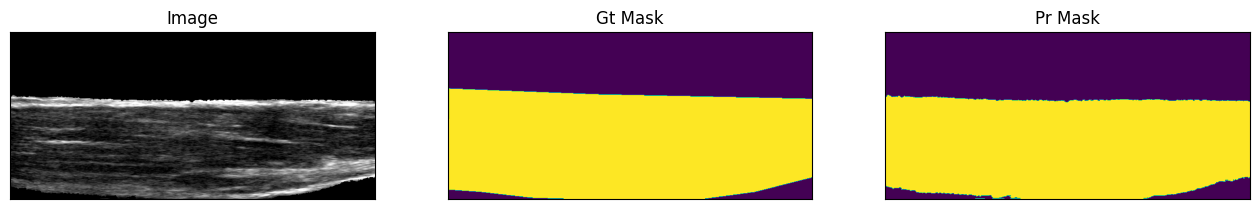

34
1/1 [==============================] - 0s 420ms/step


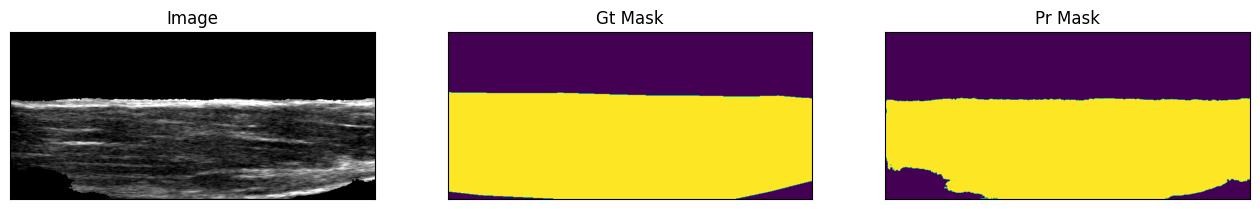

35
1/1 [==============================] - 0s 440ms/step


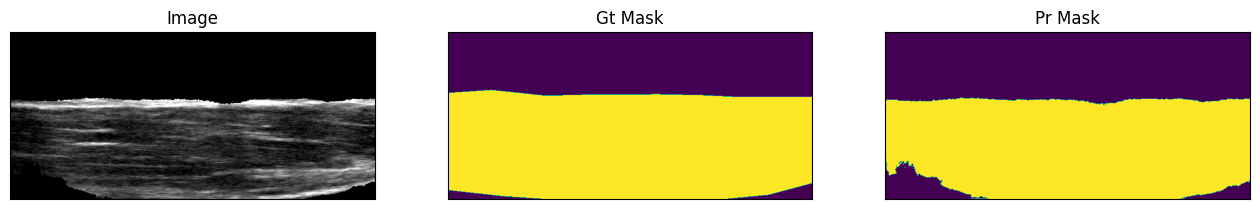

36
1/1 [==============================] - 0s 422ms/step


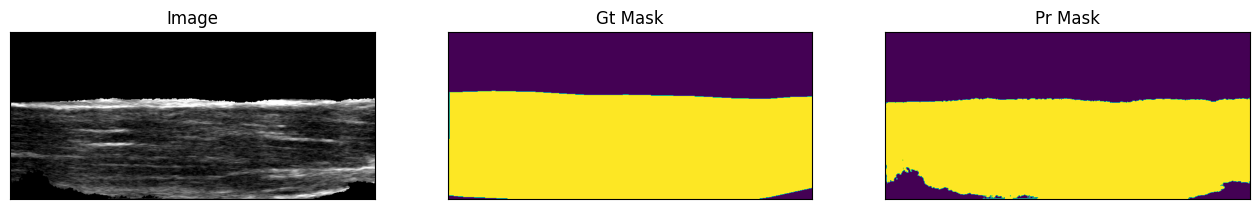

37
1/1 [==============================] - 0s 444ms/step


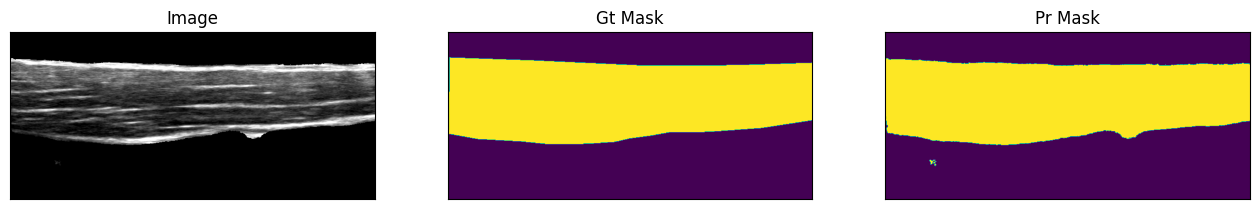

38
1/1 [==============================] - 0s 456ms/step


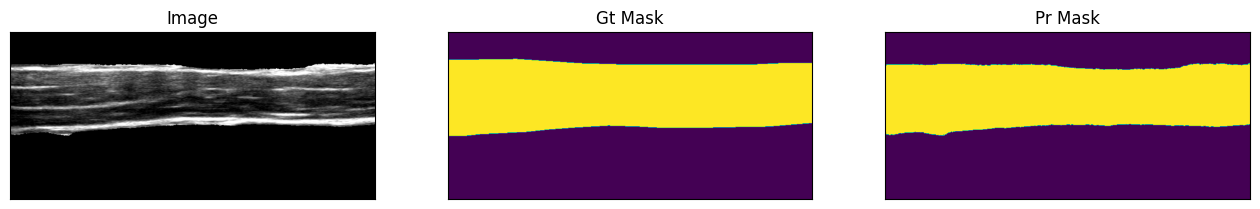

39
1/1 [==============================] - 0s 420ms/step


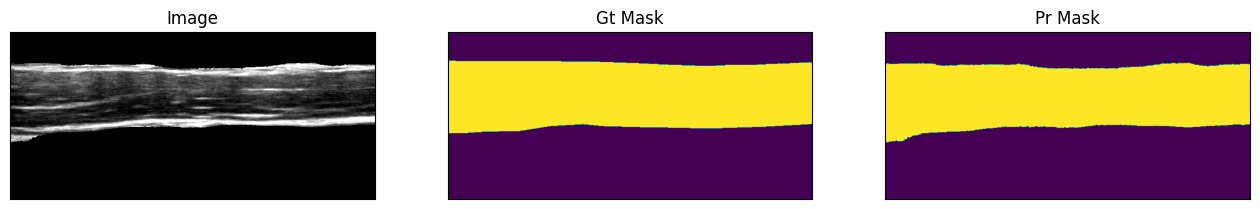

40
1/1 [==============================] - 0s 417ms/step


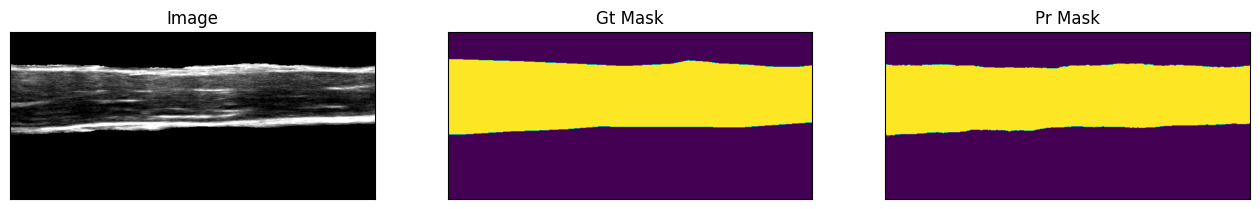

41
1/1 [==============================] - 0s 434ms/step


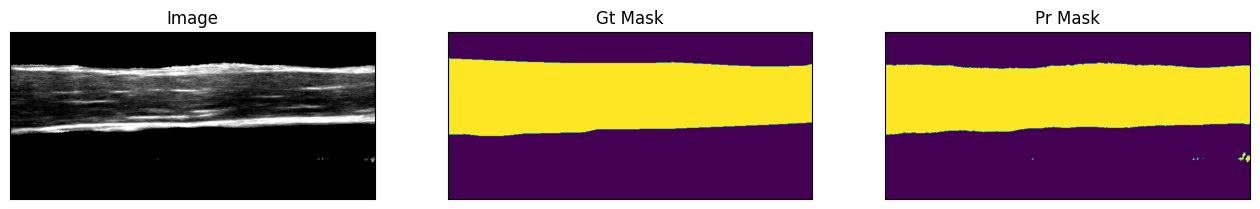

42
1/1 [==============================] - 0s 418ms/step


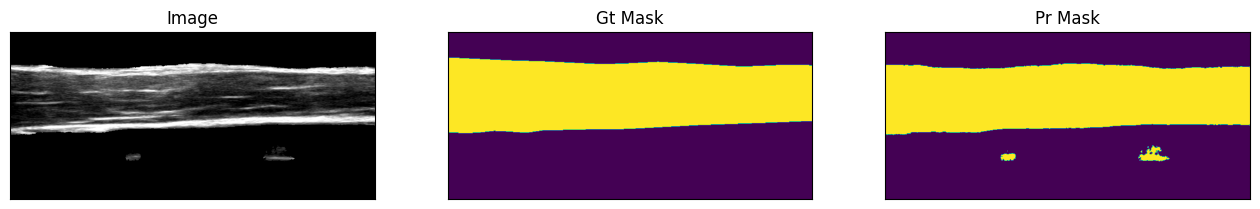

43
1/1 [==============================] - 0s 418ms/step


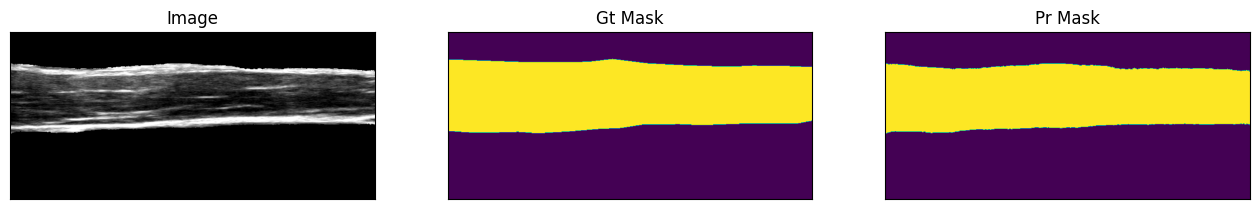

44
1/1 [==============================] - 0s 451ms/step


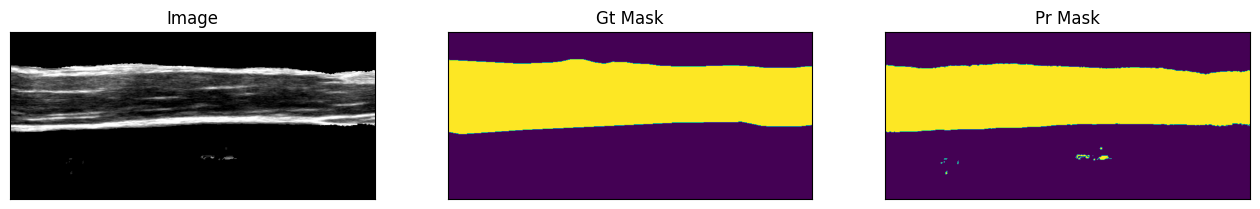

45
1/1 [==============================] - 0s 415ms/step


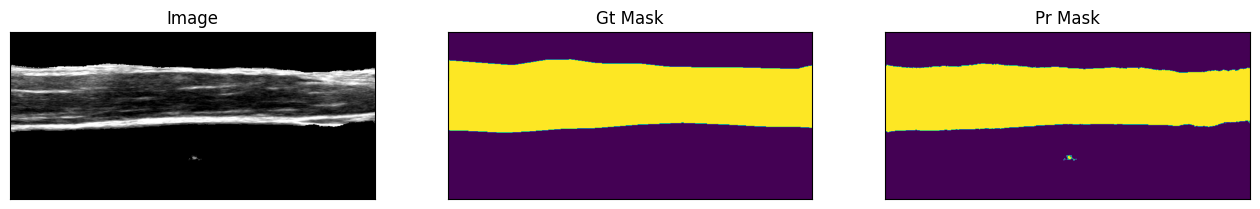

46
1/1 [==============================] - 0s 421ms/step


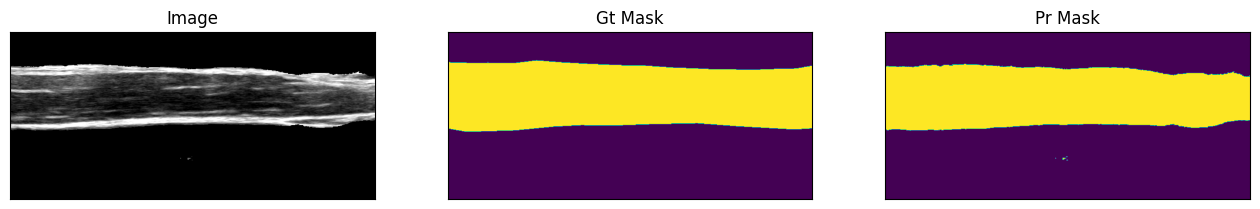

47
1/1 [==============================] - 0s 479ms/step


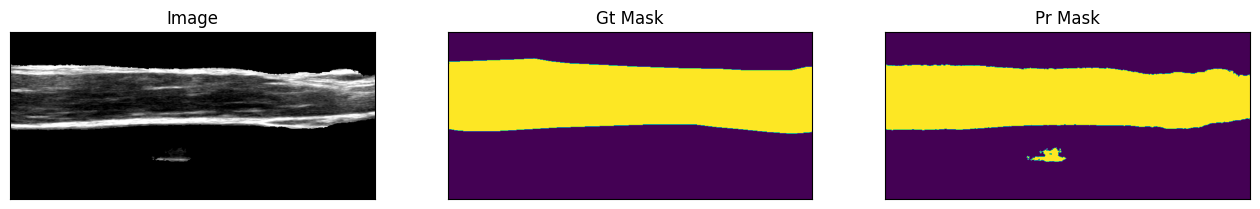

48
1/1 [==============================] - 0s 420ms/step


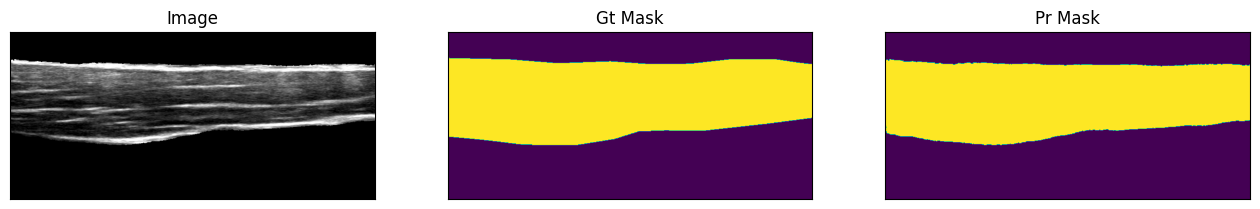

49
1/1 [==============================] - 0s 438ms/step


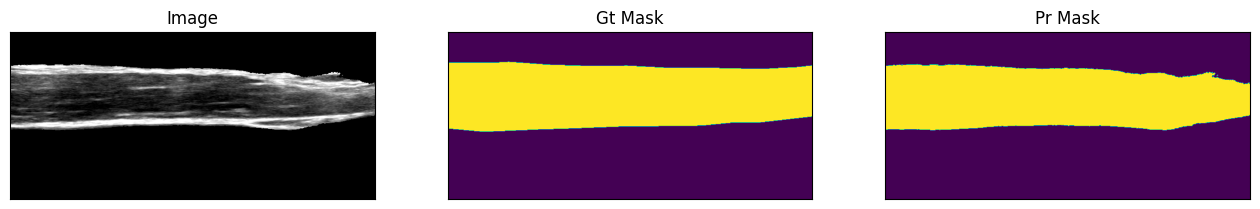

50
1/1 [==============================] - 0s 414ms/step


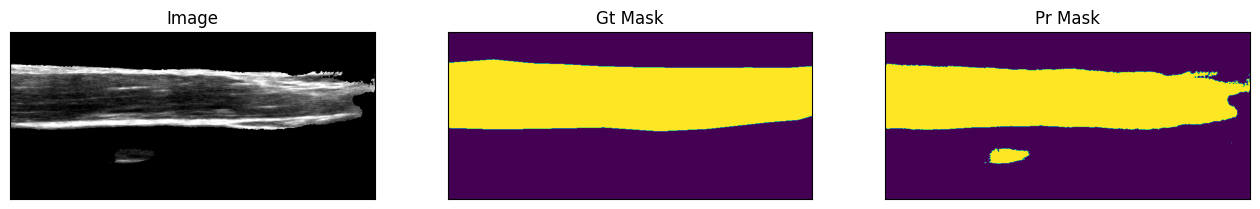

51
1/1 [==============================] - 0s 444ms/step


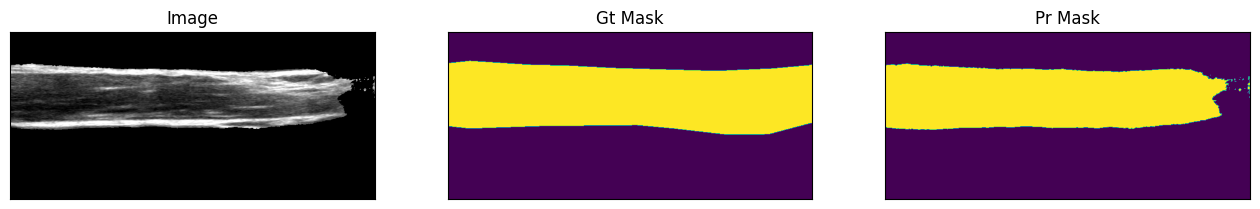

52
1/1 [==============================] - 0s 414ms/step


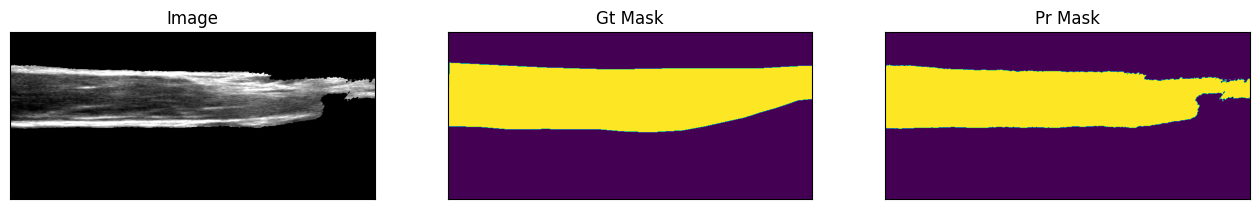

53
1/1 [==============================] - 0s 414ms/step


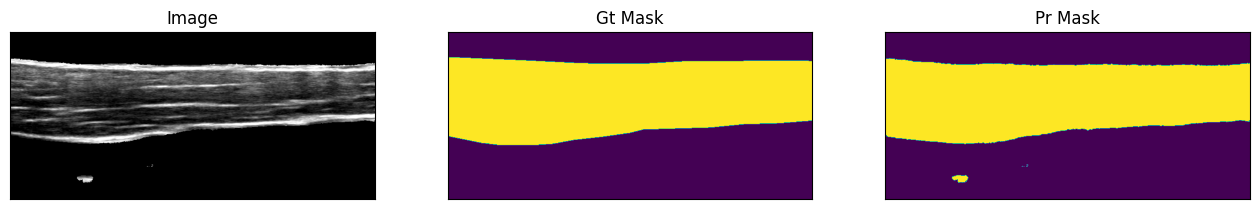

54
1/1 [==============================] - 0s 460ms/step


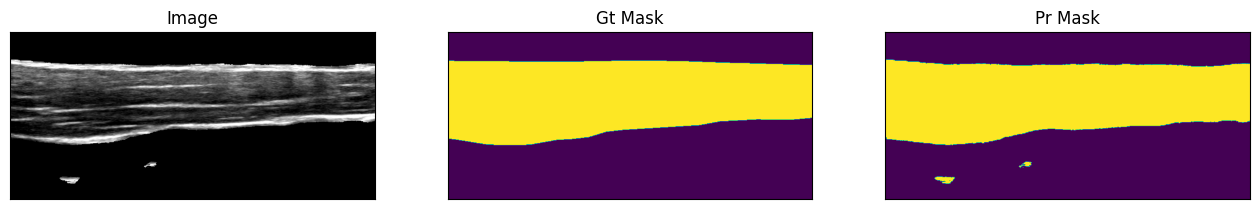

55
1/1 [==============================] - 0s 414ms/step


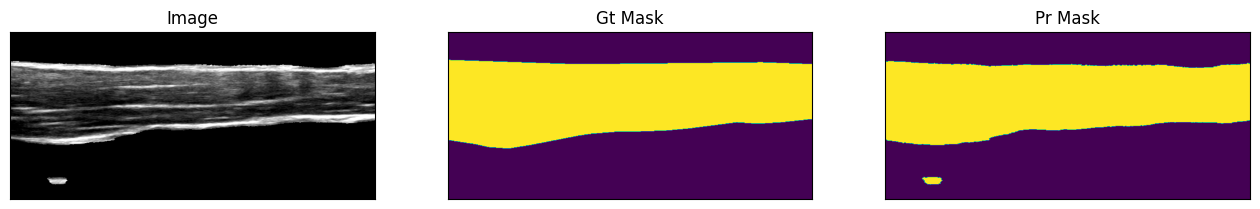

56
1/1 [==============================] - 0s 411ms/step


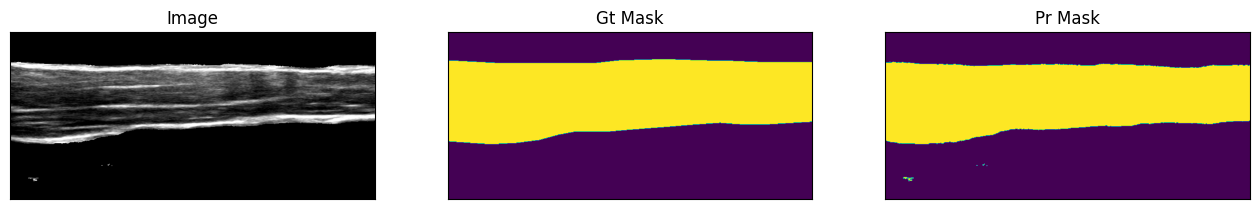

57
1/1 [==============================] - 0s 443ms/step


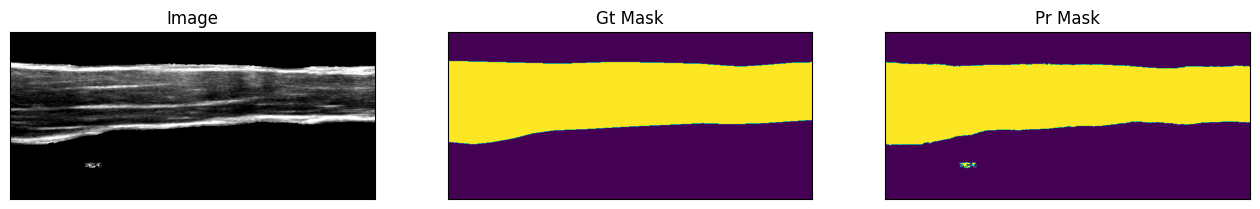

58
1/1 [==============================] - 0s 419ms/step


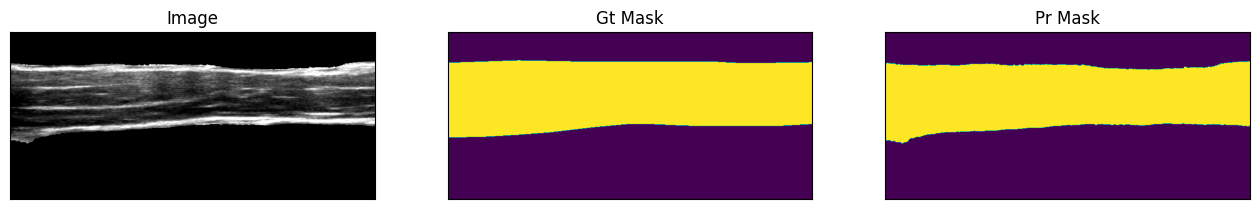

59
1/1 [==============================] - 0s 491ms/step


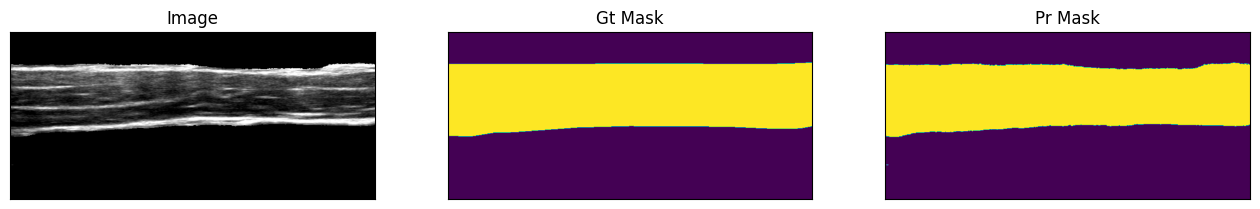

60
1/1 [==============================] - 0s 437ms/step


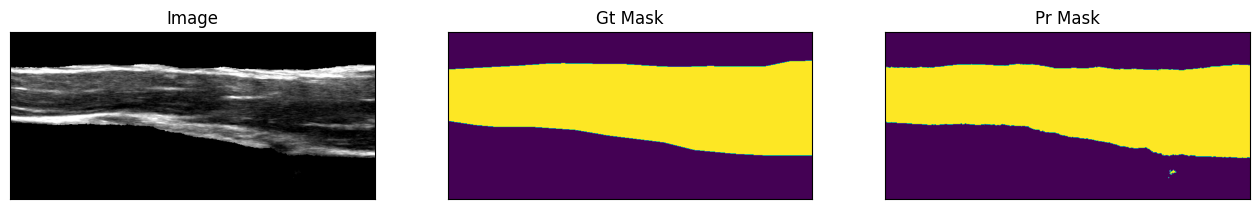

61
1/1 [==============================] - 0s 416ms/step


62
1/1 [==============================] - 0s 413ms/step


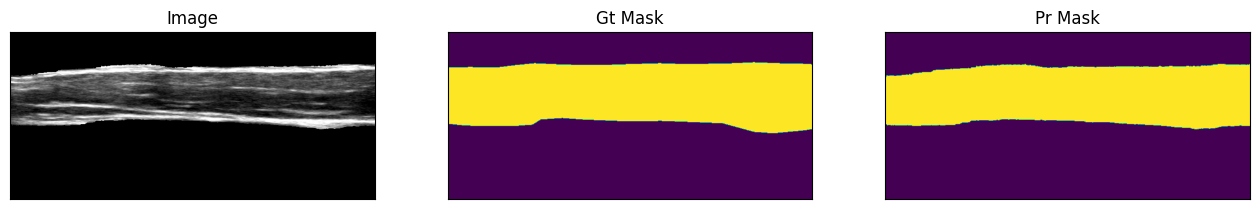

63
1/1 [==============================] - 0s 426ms/step


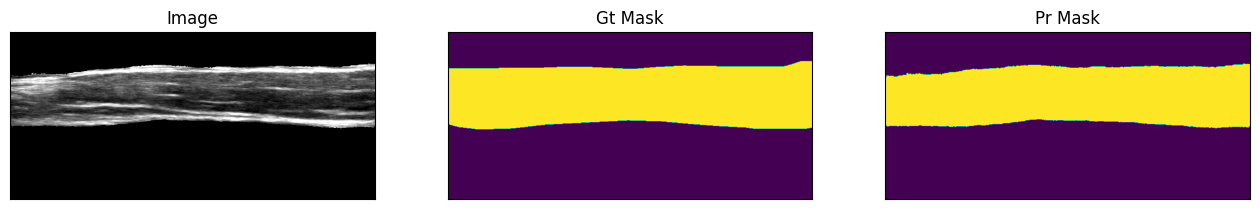

64
1/1 [==============================] - 0s 416ms/step


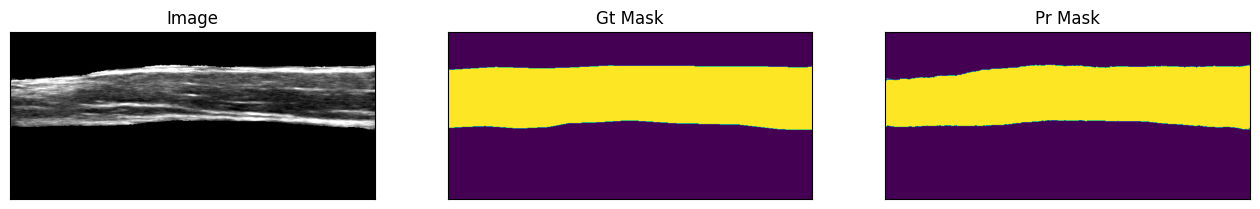

65
1/1 [==============================] - 0s 417ms/step


66
1/1 [==============================] - 0s 426ms/step


67
1/1 [==============================] - 0s 415ms/step


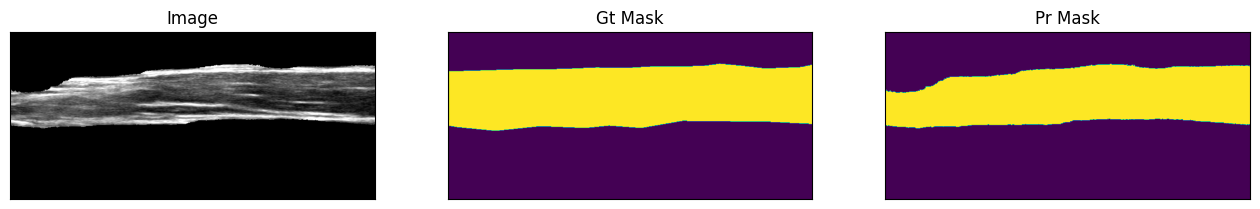

68
1/1 [==============================] - 0s 443ms/step


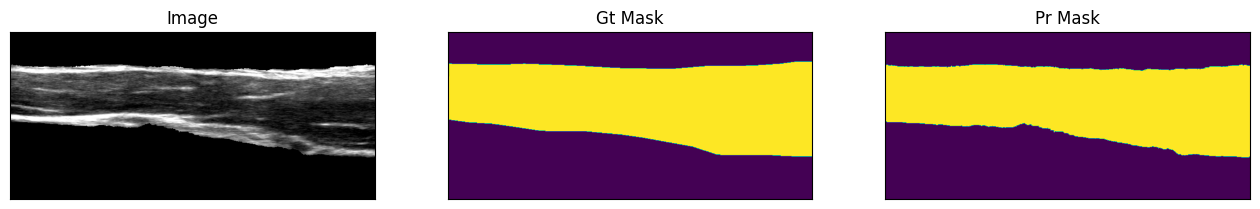

69
1/1 [==============================] - 0s 422ms/step


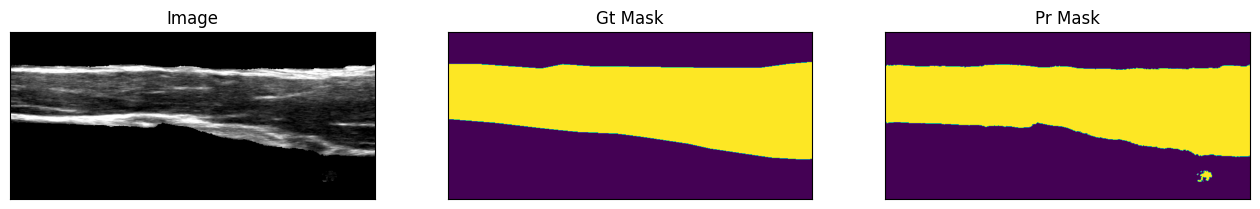

70
1/1 [==============================] - 0s 408ms/step


71
1/1 [==============================] - 0s 445ms/step


72
1/1 [==============================] - 0s 415ms/step


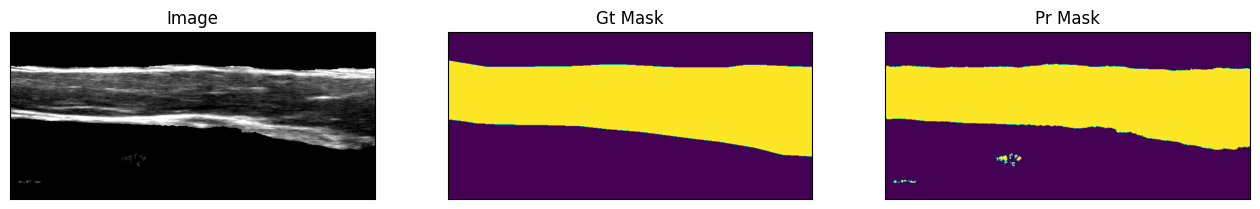

73
1/1 [==============================] - 0s 418ms/step


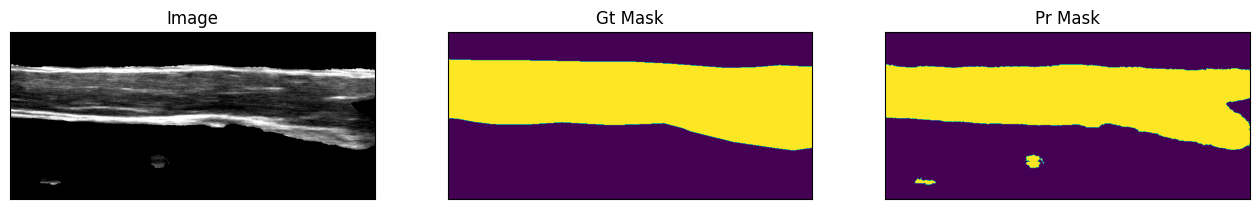

74
1/1 [==============================] - 0s 436ms/step


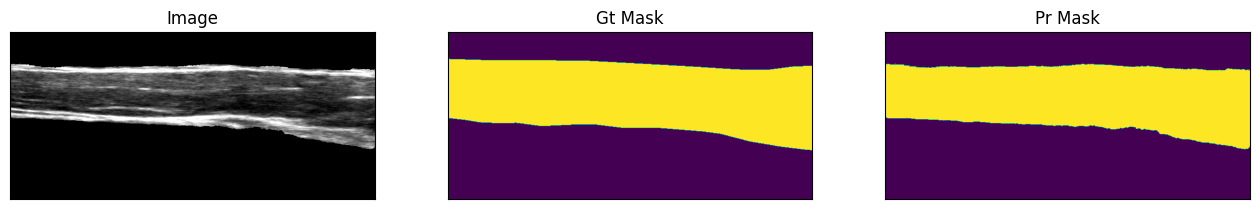

75
1/1 [==============================] - 0s 413ms/step


76
1/1 [==============================] - 0s 414ms/step


77
1/1 [==============================] - 0s 443ms/step


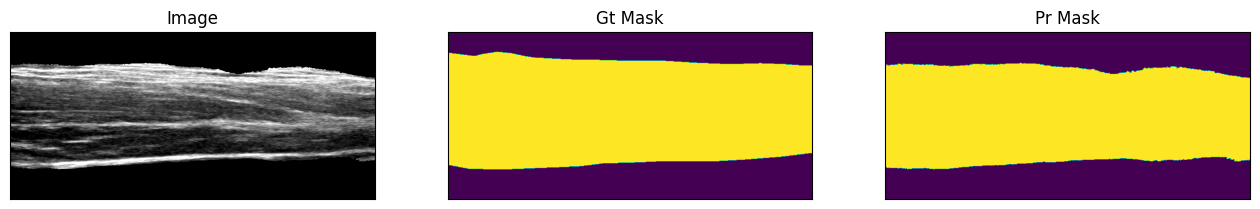

78
1/1 [==============================] - 0s 420ms/step


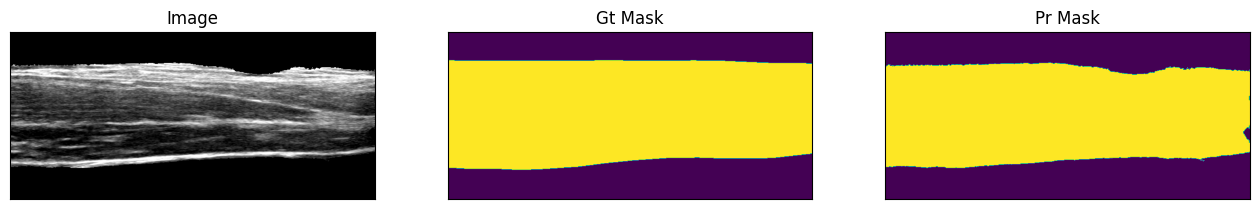

79
1/1 [==============================] - 0s 416ms/step


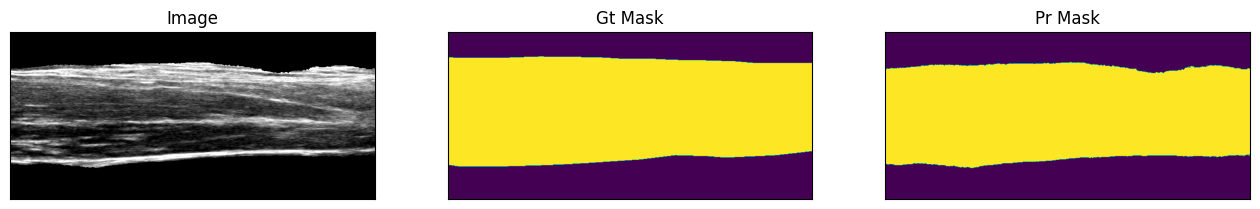

80
1/1 [==============================] - 0s 426ms/step


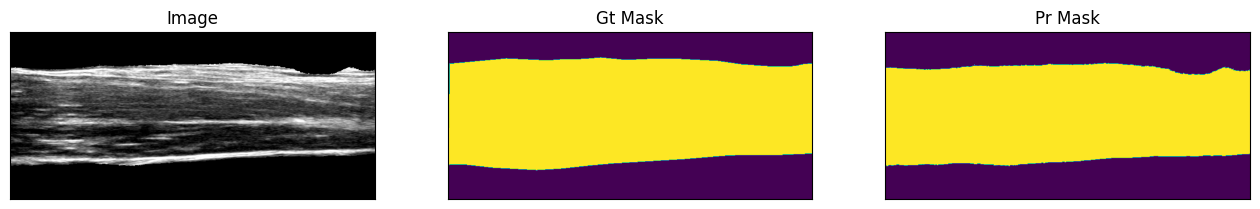

81
1/1 [==============================] - 0s 417ms/step


82
1/1 [==============================] - 0s 419ms/step


83
1/1 [==============================] - 0s 423ms/step


84
1/1 [==============================] - 0s 415ms/step


85
1/1 [==============================] - 0s 431ms/step


86
1/1 [==============================] - 0s 417ms/step


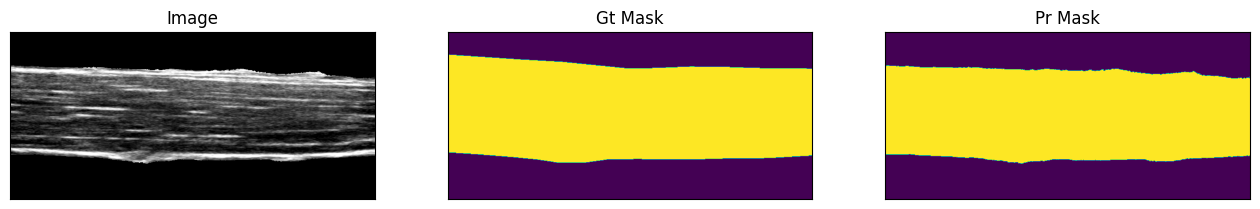

87
1/1 [==============================] - 0s 475ms/step


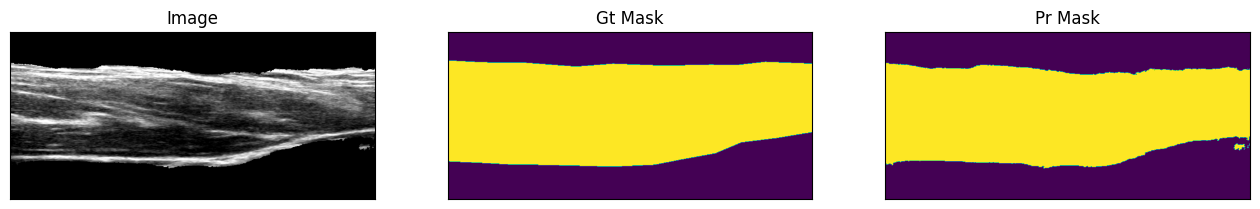

88
1/1 [==============================] - 0s 427ms/step


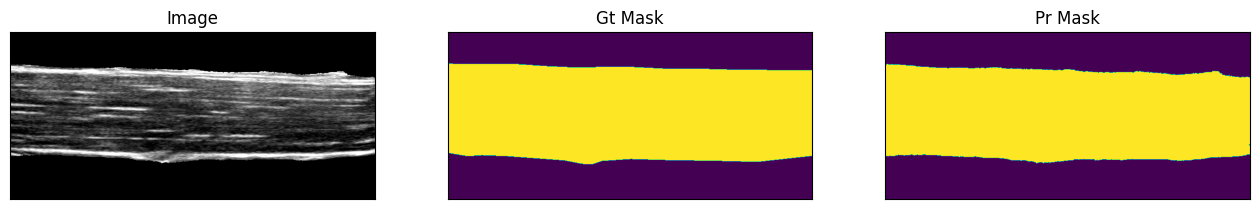

89
1/1 [==============================] - 0s 478ms/step


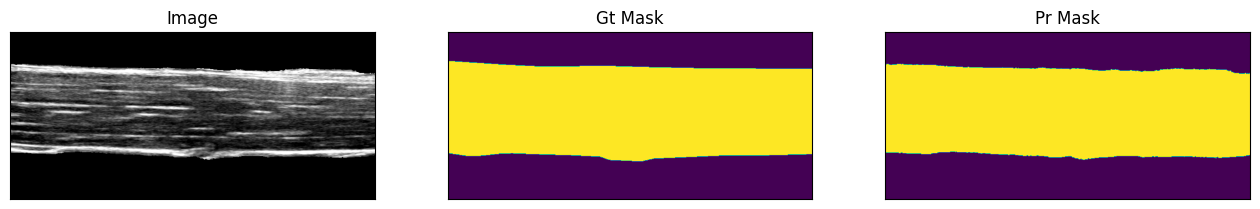

90
1/1 [==============================] - 0s 418ms/step


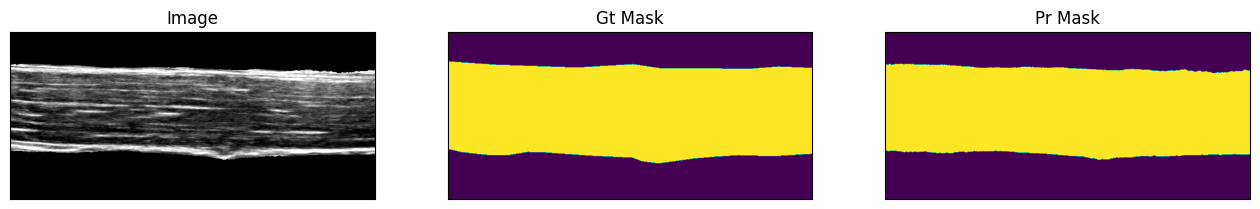

91
1/1 [==============================] - 0s 423ms/step


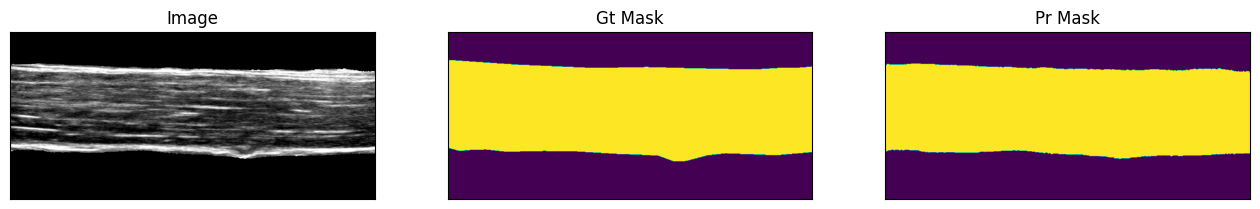

92
1/1 [==============================] - 0s 440ms/step


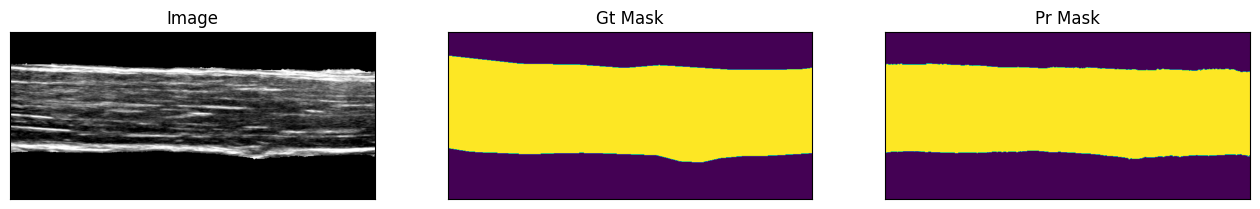

93
1/1 [==============================] - 0s 423ms/step


94
1/1 [==============================] - 0s 437ms/step


95
1/1 [==============================] - 0s 425ms/step


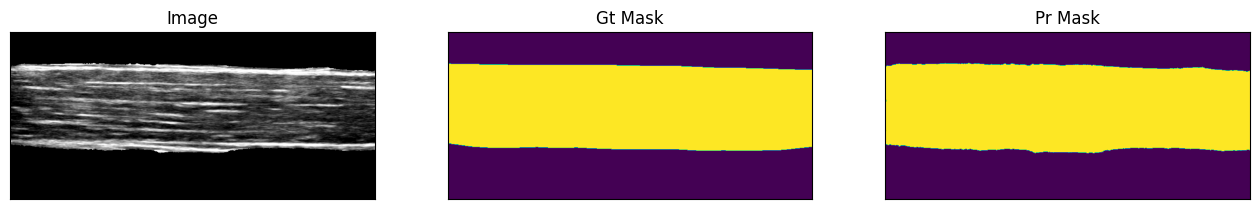

96
1/1 [==============================] - 0s 424ms/step


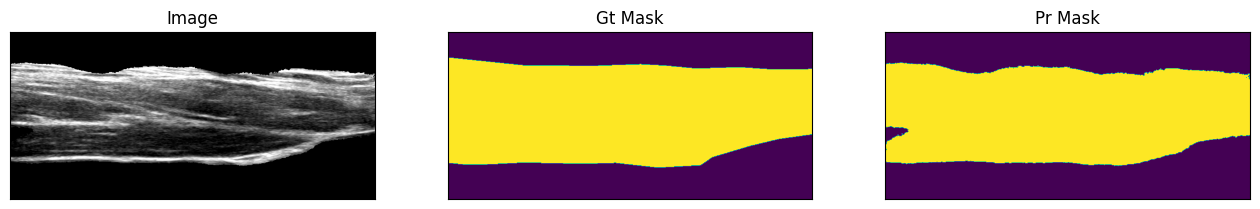

97
1/1 [==============================] - 0s 433ms/step


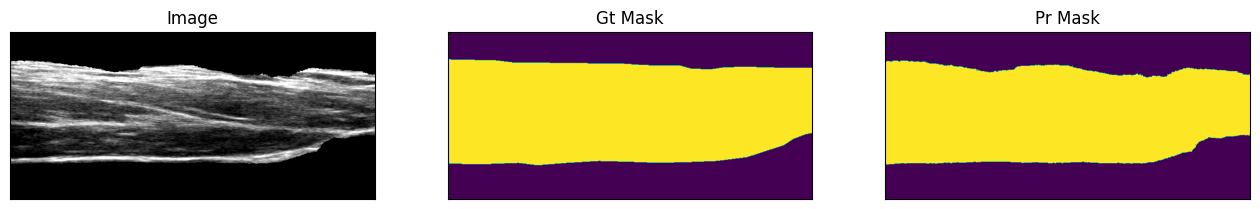

98
1/1 [==============================] - 0s 422ms/step


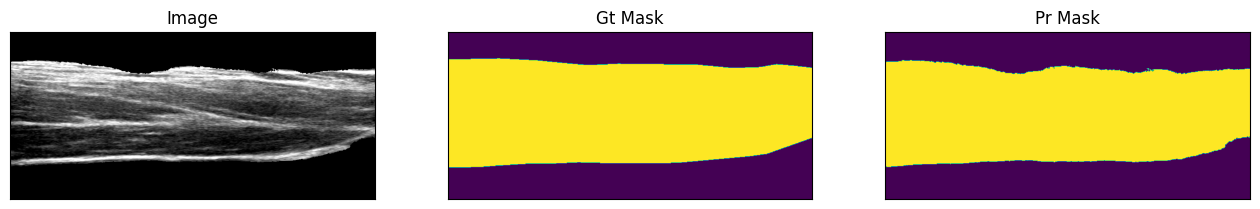

99
1/1 [==============================] - 0s 425ms/step


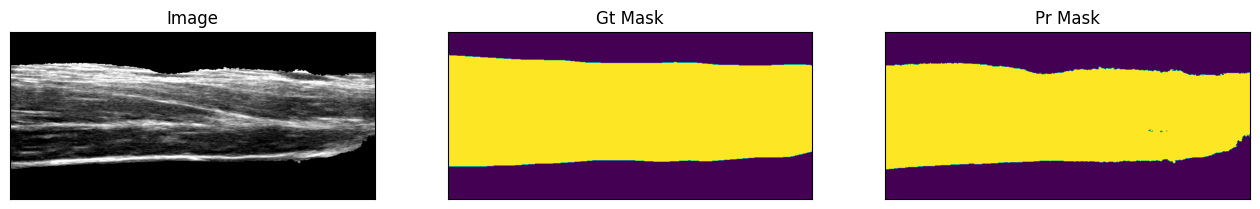

100
1/1 [==============================] - 0s 429ms/step


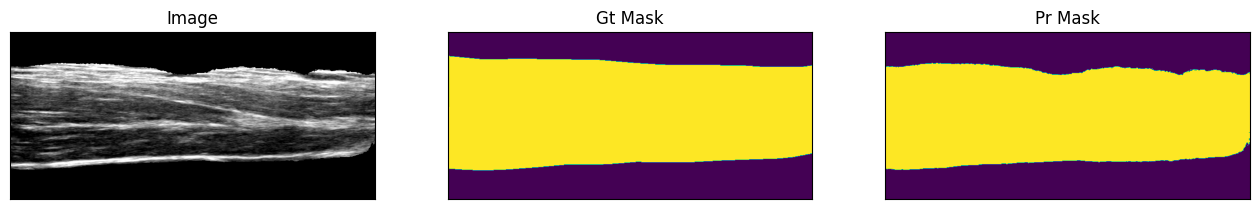

101
1/1 [==============================] - 0s 424ms/step


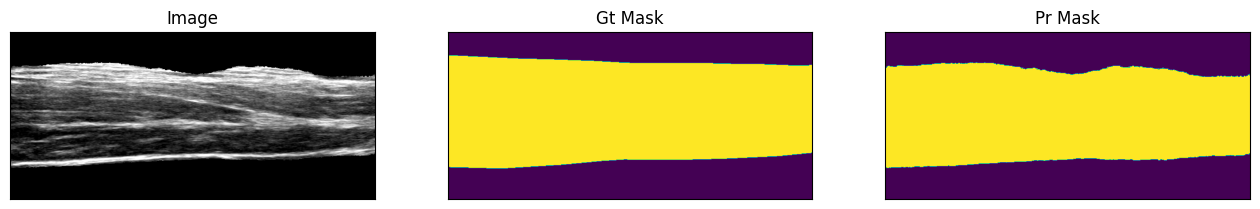

102
1/1 [==============================] - 0s 430ms/step


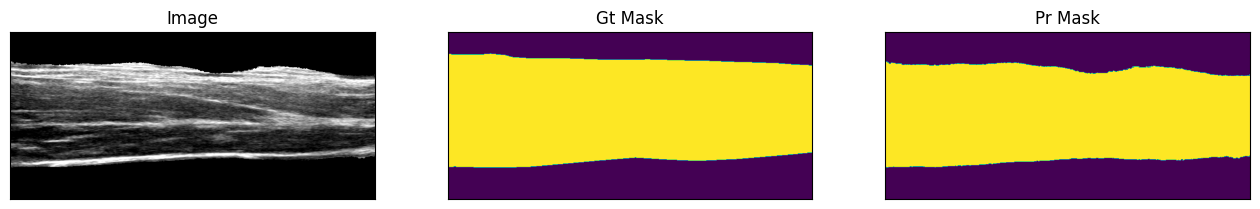

103
1/1 [==============================] - 0s 436ms/step


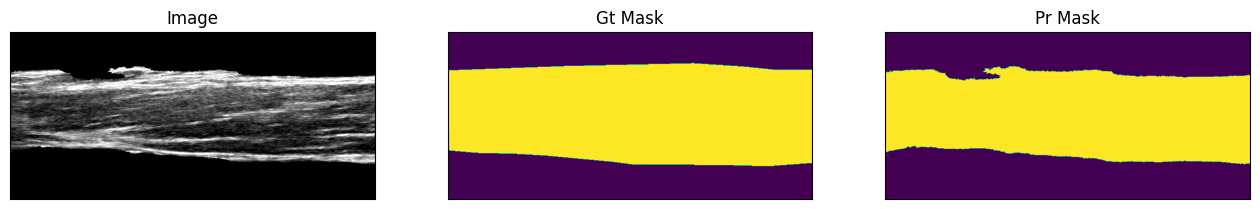

104
1/1 [==============================] - 0s 418ms/step


105
1/1 [==============================] - 0s 421ms/step


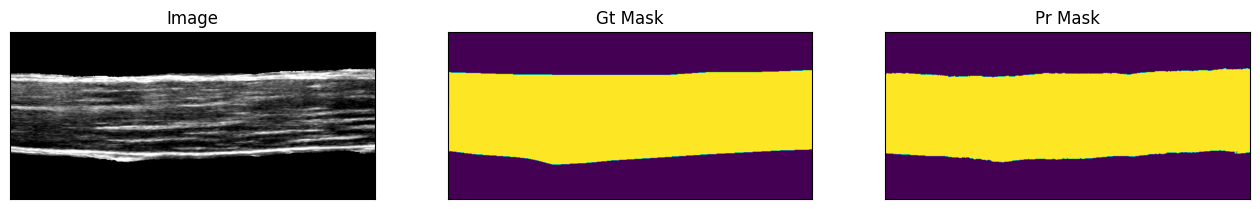

106
1/1 [==============================] - 0s 417ms/step


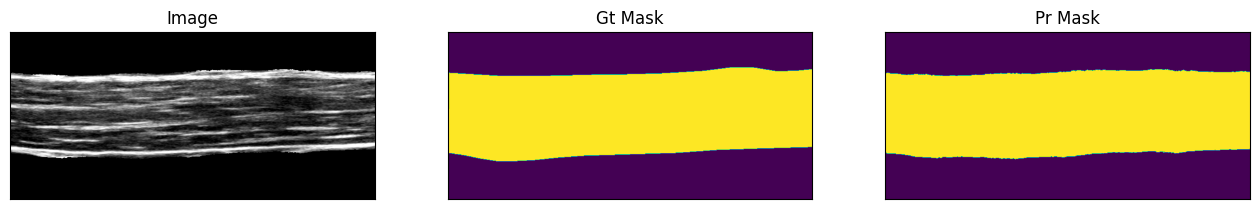

107
1/1 [==============================] - 0s 423ms/step


108
1/1 [==============================] - 0s 422ms/step


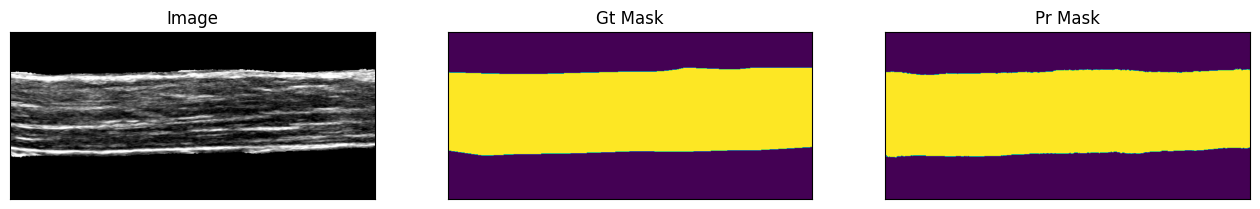

109
1/1 [==============================] - 0s 419ms/step


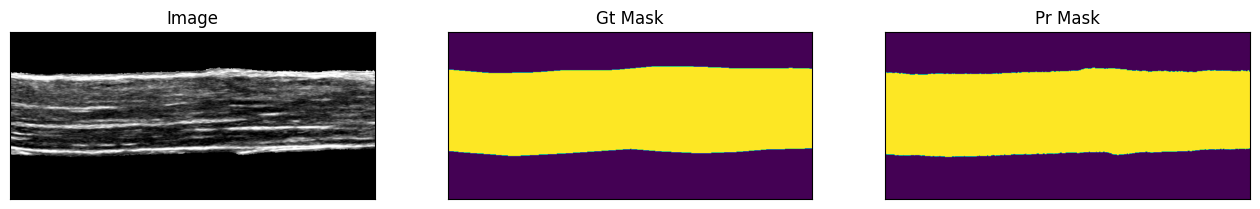

110
1/1 [==============================] - 0s 421ms/step


111
1/1 [==============================] - 0s 420ms/step


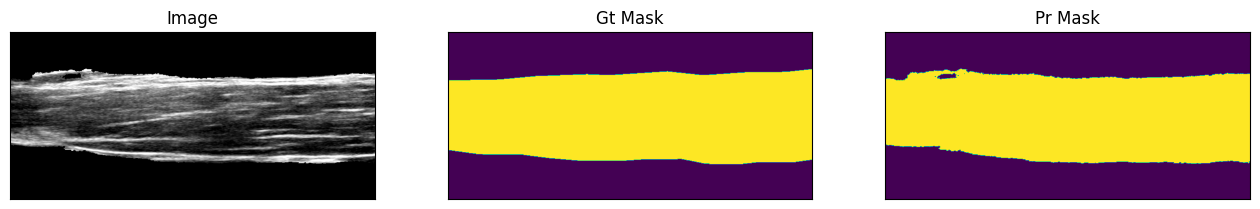

112
1/1 [==============================] - 1s 506ms/step


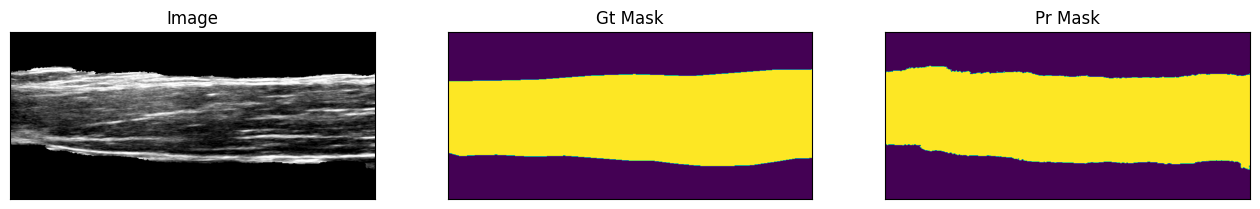

113
1/1 [==============================] - 0s 421ms/step


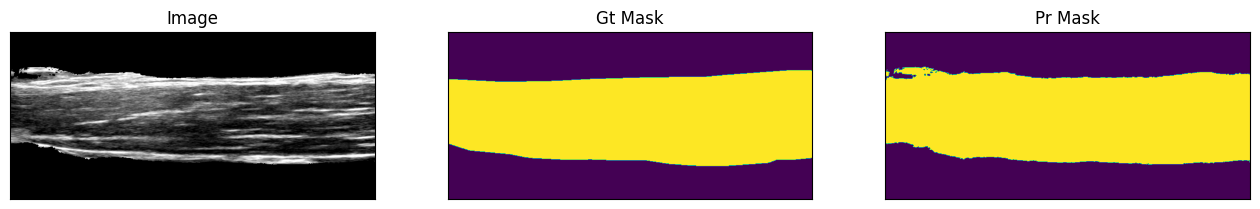

114
1/1 [==============================] - 0s 432ms/step


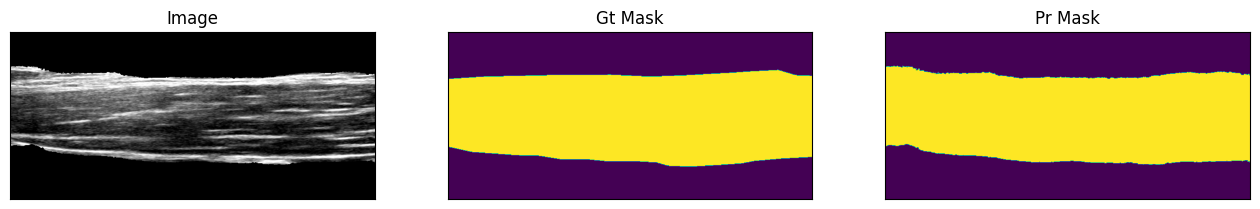

115
1/1 [==============================] - 0s 421ms/step


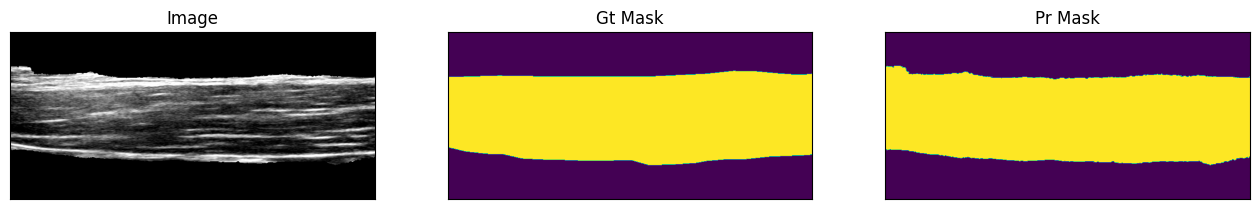

116
1/1 [==============================] - 0s 421ms/step


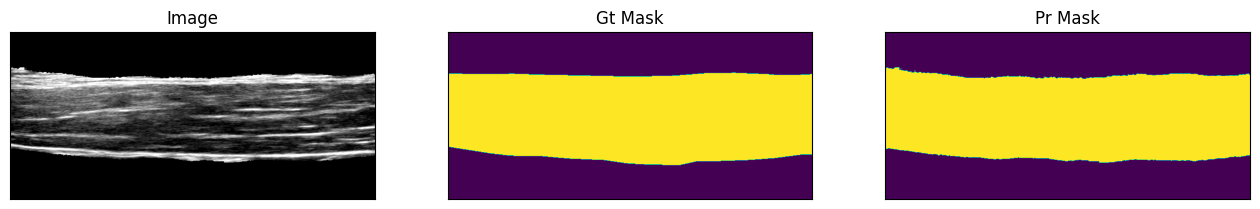

117
1/1 [==============================] - 0s 429ms/step


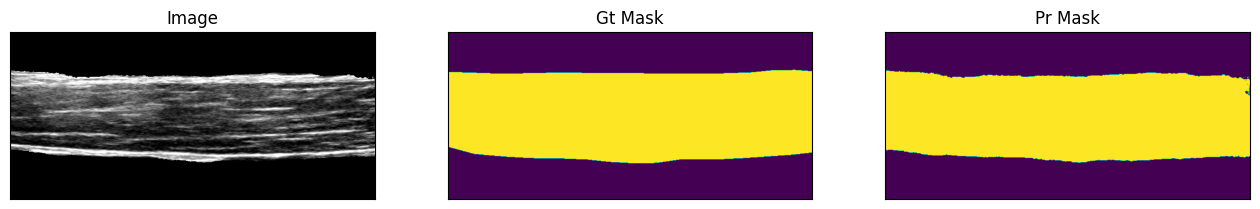

118
1/1 [==============================] - 0s 417ms/step


In [203]:
DATA_DIR = 'images_all/'
x_all_dir = os.path.join(DATA_DIR, 'img')
y_all_dir = os.path.join(DATA_DIR, 'mask')

all_dataset = Dataset(
    x_all_dir,
    y_all_dir,
    classes=None,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

all_dataset_1 = Dataset(
    x_all_dir,
    y_all_dir
)

# Set Save Directory
save_dir = "images_all/cropped_images"
os.makedirs(save_dir, exist_ok=True)

# n = 5
# ids = np.arange(n)

ids = np.arange(len(all_dataset))

for i in ids:

    print(i)

    image, gt_mask = all_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    image_2, gt_mask_2 = all_dataset_1[i]
    masked_image = denormalize(image_2.squeeze()) * np.expand_dims(pr_mask.squeeze(), axis=-1)

    # Save the cropped image
    save_path = os.path.join(save_dir, f"masked_image_{i}.png")
    plt.imsave(save_path, masked_image)

    visualize(
        # image=denormalize(image.squeeze()),
        image=masked_image,
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )


Obtain Cropped Image - TEST IMAGES

2
1/1 [==============================] - 0s 426ms/step


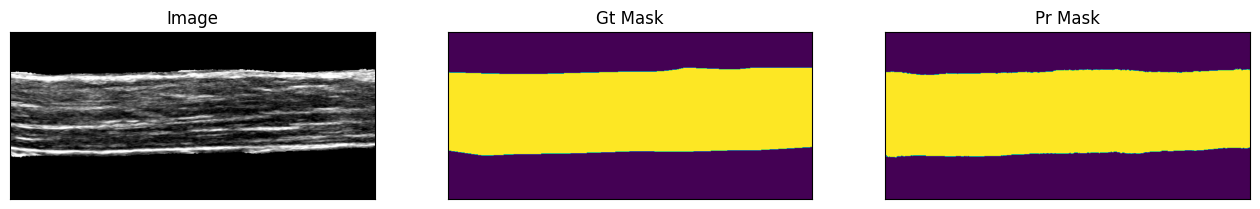

3
1/1 [==============================] - 0s 463ms/step


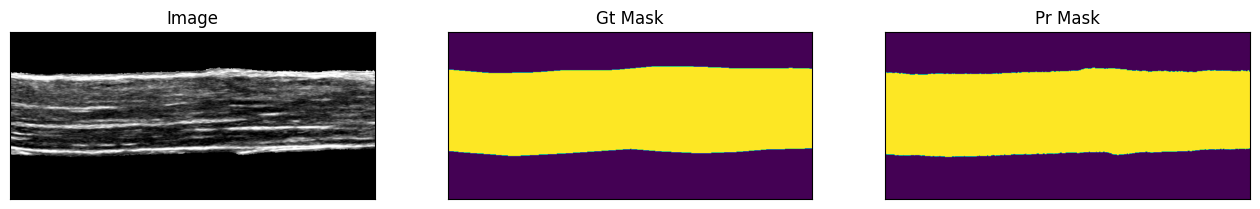

0
1/1 [==============================] - 0s 435ms/step


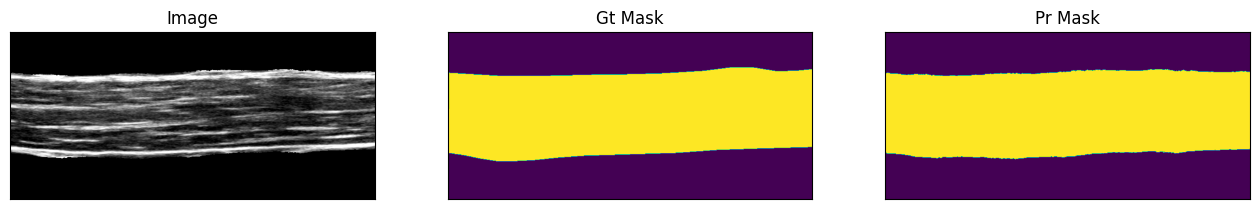

4
1/1 [==============================] - 0s 422ms/step


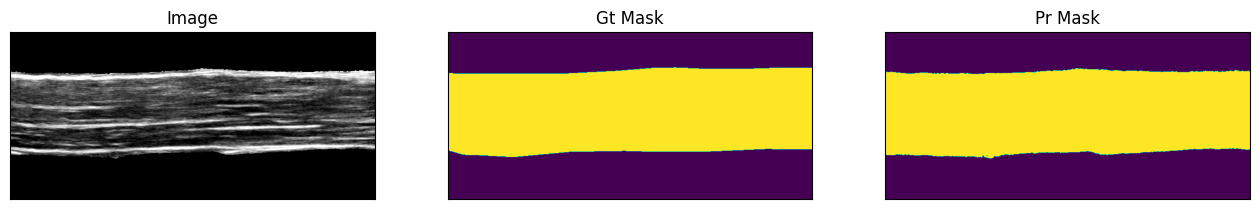

1
1/1 [==============================] - 0s 428ms/step


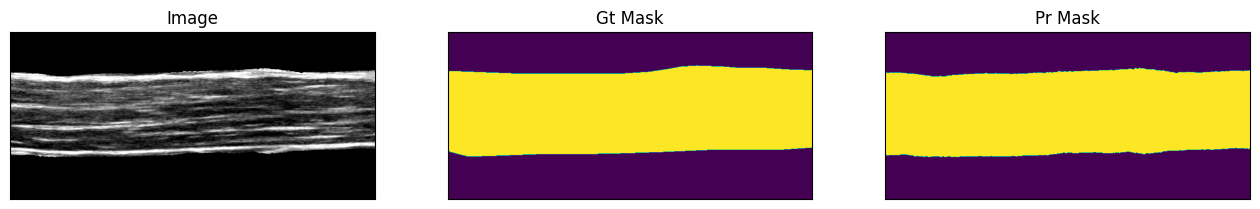

In [201]:
## NOTE: CHANGE DIRECTORY WHERE IMAGES ARE SAVED ##

# Set Save Directory
# save_dir = "images_all/cropped_images"
# os.makedirs(save_dir, exist_ok=True)

all_dataset_1 = Dataset(
    x_test_dir,
    y_test_dir
)

n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    print(i)

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    image_2, gt_mask_2 = all_dataset_1[i]
    masked_image = denormalize(image_2.squeeze()) * np.expand_dims(pr_mask.squeeze(), axis=-1)

    # Save the cropped image
    # save_path = os.path.join(save_dir, f"masked_image_{i}.png")
    # plt.imsave(save_path, masked_image)

    visualize(
        # image=denormalize(image.squeeze()),
        image=masked_image,
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

